In [23]:
from time import time

import jax
import jax.numpy as jnp
from jax import grad, value_and_grad, vmap, jit, random
import equinox as eqx
import optax
import matplotlib.pyplot as plt

from playground_jax.models import *

Goal: fit a scalar real-valued funciton
$ f: D \subset \mathbb{R} \rightarrow \mathbb{R}$

1. Generate training data

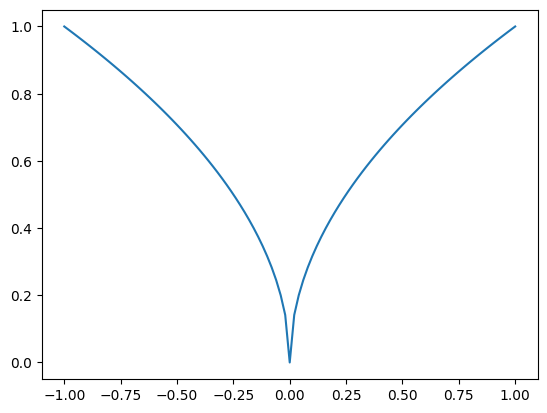

In [9]:
N = 101
x = jnp.expand_dims(jnp.linspace(-1, 1, N), axis=-1)
y = jnp.sqrt(jnp.abs(x))
#y = x**2
fig, ax = plt.subplots()
ax.plot(x, y)

2. build a model

In [17]:
# set a random key
key = random.PRNGKey(1)

# Generate random data for input
d_in, d_hidden, d_out = 1, 128, 1

#model = Linear(d_in, d_out, key=key)
model = FeedForwardNN(d_in, d_out, d_hidden, key=key)

3. Define loss (mean square error loss)

In [18]:
def loss_fn(model, x, y):
    pred_y = vmap(model, in_axes=0, out_axes=0)(x)
    return jnp.mean((y - pred_y) ** 2)

4. Choose optimizer

In [19]:
lr = 1e-3
opt = optax.adam(learning_rate=lr)
opt_state = opt.init(model)

5. Update function

In [20]:
@jit
def update_fn(model, opt_state, x, y):
    loss, grads = value_and_grad(loss_fn)(model, x, y)

    # manual sgd update
    #model = jax.tree_map(lambda m, g: m - lr * g, model, grads)

    # optimizer upate
    updates, opt_state = opt.update(grads, opt_state)
    model = optax.apply_updates(model, updates)
    return loss, model, opt_state

6. Train

In [21]:
n_iter = int(1e4)
log_period_iter = int(1e3)
for i in range(n_iter):
    t0 = time()
    loss, model, opt_state = update_fn(model, opt_state, x, y)
    t1 = time()
    if i % log_period_iter  == 0: 
        print('it: {:d}, loss: {:.3e}, time: {:.4f}s'.format(i, loss, t1-t0))

it: 0, loss: 6.656e-01, time: 0.1359s
it: 1000, loss: 4.957e-04, time: 0.0002s
it: 2000, loss: 1.902e-04, time: 0.0002s
it: 3000, loss: 1.369e-04, time: 0.0002s
it: 4000, loss: 8.873e-05, time: 0.0002s
it: 5000, loss: 6.462e-05, time: 0.0003s
it: 6000, loss: 4.540e-05, time: 0.0002s
it: 7000, loss: 2.850e-05, time: 0.0003s
it: 8000, loss: 1.425e-05, time: 0.0002s
it: 9000, loss: 5.734e-06, time: 0.0002s


7. Evaluate results

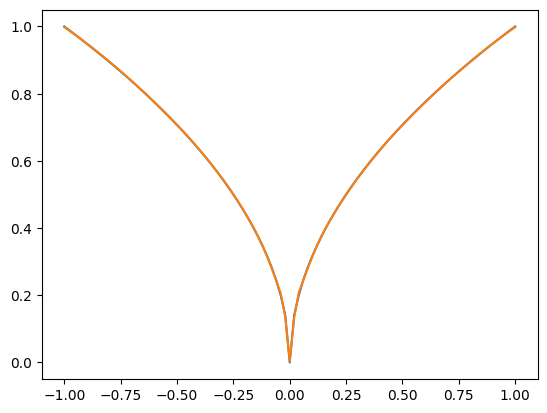

In [22]:
y_pred = vmap(model)(x)
fig, ax = plt.subplots()
ax.plot(x, y)
ax.plot(x, y_pred)